In [9]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.spatial.distance import cdist
from scipy.stats import kurtosis
from sklearn import tree
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, TruncatedSVD, FastICA
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer, log_loss, plot_confusion_matrix, silhouette_score, calinski_harabasz_score, \
    davies_bouldin_score, silhouette_samples, homogeneity_score, completeness_score, v_measure_score, \
    adjusted_mutual_info_score, mean_squared_error
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.random_projection import GaussianRandomProjection
from sklearn.tree import plot_tree
from sklearn.metrics.cluster import adjusted_rand_score
import nltk
import re
from yellowbrick.cluster import KElbowVisualizer, InterclusterDistance
from sklearn.neural_network import MLPClassifier
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings

# warnings.filterwarnings("ignore")

data = pd.read_csv("bbc-text.csv")
print(data['category'].value_counts())
data['text_clean'] = data['text'].apply(nltk.word_tokenize)
print('done tokenize')
stop_words=set(nltk.corpus.stopwords.words("english"))
data['text_clean'] = data['text_clean'].apply(lambda x: [item for item in x if item not in stop_words])
regex = '[a-z]+'
print('done stop words')
data['text_clean'] = data['text_clean'].apply(lambda x: [item for item in x if re.match(regex, item)])
lem = nltk.stem.wordnet.WordNetLemmatizer()
data['text_clean'] = data['text_clean'].apply(lambda x: [lem.lemmatize(item, pos='v') for item in x])
print("done lemmatizer")


# data = shuffle(data)
# std_scaler = StandardScaler()
# copy_both_df = data.copy()
X = data.loc[:, data.columns != "category"]
y_label = data['category']
# std_scaler.fit(X)
# X_scaled = std_scaler.fit_transform(X)
enc = LabelEncoder()
y = enc.fit_transform(data['category'])
labels = list(enc.classes_)

# dtc = tree.DecisionTreeClassifier(criterion="entropy", max_depth=20, min_samples_split=15, random_state = 3)
# X_train, X_test, y_train, y_test = train_test_split(data['text'], y, random_state=2, test_size=.2, stratify=y)
vec = TfidfVectorizer()
# X_train_vec = vec.fit_transform(X_train)
# X_test_vec = vec.transform(X_test)

X_scaled_prevec = data['text']
X_scaled = vec.fit_transform(X_scaled_prevec)
y_encode = y
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encode, random_state=2, test_size=.4, stratify=y_encode)
print("done preparing data")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Stephen\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Stephen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Stephen\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64
done tokenize
done stop words
done lemmatizer
done preparing data


(1335, 29421)
(29421,)
0.9947565543071161
0.9370786516853933
Feature ranking:


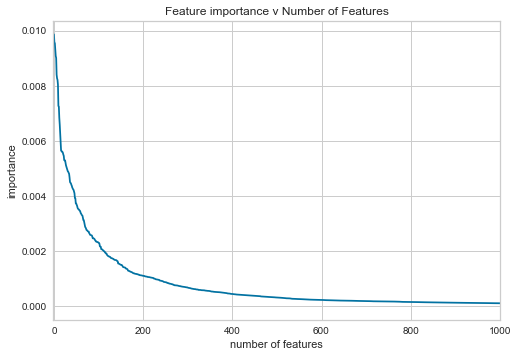

In [19]:
rf = RandomForestClassifier(n_estimators=1000,
                            n_jobs=-1,
                            max_depth=10,
                            min_samples_split=5,
                            oob_score=True,
                            warm_start=True)
rf.fit(X_train, y_train)
print(X_train.shape)
print(rf.feature_importances_.shape)
print(rf.score(X_train, y_train))
print(rf.score(X_test, y_test))
#print(np.sort(rf.feature_importances_))

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
features = []
for f in range(X_train.shape[1]):
    features.append(importances[indices[f]])
    #print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, 1000])
plt.plot(features)
plt.xlabel('number of features')
plt.ylabel('importance')
plt.title("Feature importance v Number of Features")
plt.show()

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encode, random_state=2, test_size=.3, stratify=y_encode)
# dtc.fit(X_train, y_train)
#
# y_probas = dtc.predict_proba(X_test)
# y_temp = log_loss(y_test, y_probas)
# print("log loss: ", y_temp)
#

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
range_n_clusters = range(2,21)
silhouette = []
distortion = []
inertia = []
ch = []
db = []
best_silhouette = 0
temp_silhouette = 0
k_silhouette = 0

best_distortion = 99999999
temp_distortion = 0
k_distortion = 0

best_inertia = 99999999
temp_inertia = 0
k_inertia = 0
X_scaled = X_scaled.toarray()
for n_clusters in range_n_clusters:

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=1, algorithm='auto', max_iter=1000)
    cluster_labels = clusterer.fit_predict(X_scaled)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_scaled, cluster_labels, metric='euclidean')
    ch_avg = calinski_harabasz_score(X_scaled, cluster_labels)
    db_avg = davies_bouldin_score(X_scaled, cluster_labels)
    distortion_score = sum(np.min(cdist(X_scaled, clusterer.cluster_centers_,
                      'euclidean'),axis=1)) / X_scaled.shape[0]
    silhouette.append(silhouette_avg)
    distortion.append(distortion_score)
    inertia.append(clusterer.inertia_)
    ch.append(ch_avg)
    db.append(db_avg)
    temp_silhouette = silhouette_avg
    if temp_silhouette > best_silhouette:
        best_silhouette = temp_silhouette
        k_silhouette = n_clusters
    if temp_distortion < best_distortion:
        best_distortion = temp_distortion
        k_distortion = n_clusters
    if temp_inertia < best_inertia:
        best_inertia = temp_inertia
        k_inertia = n_clusters
#
# plt.plot(range_n_clusters, inertia, 'bx-')
# plt.xlabel('Values of K')
# plt.ylabel('Inertia')
# plt.xlim(2, 20)
# plt.title('The Elbow Method using Inertia')
# plt.show()
#
# plt.plot(range_n_clusters, distortion, 'bx-')
# plt.xlabel('Values of K')
# plt.ylabel('Distortion')
# plt.xlim(2, 20)
# plt.title('The Elbow Method using Distortion')
# plt.show()

plt.plot(range_n_clusters, silhouette, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette')
plt.xlim(2, 20)
plt.title('The Silhouette Method')
plt.show()
plt.plot(range_n_clusters, silhouette, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('davies-bouldin')
plt.xlim(2, 20)
plt.title('The davies-bouldin Method')
plt.show()
plt.plot(range_n_clusters, silhouette, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Calinski-Harabasz')
plt.xlim(2, 20)
plt.title('The Calinski-Harabasz Method')
plt.show()

print("best silhouette :", best_silhouette, " k value :", k_silhouette)
print("best distortion :", best_distortion, " k value :", k_distortion)
print("best inertia :", best_silhouette, " k value :", k_inertia)

k_silhouette = 11
 # Compute the silhouette scores for each sample
clusterer = KMeans(n_clusters=k_silhouette, random_state=1, algorithm='auto', max_iter=1000)
cluster_labels = clusterer.fit_predict(X_scaled)
silhouette_avg = silhouette_score(X_scaled, cluster_labels, metric='euclidean')
sample_silhouette_values = silhouette_samples(X_scaled, cluster_labels)
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(X_scaled) + (k_silhouette + 1) * 10])
y_lower = 10
for i in range(k_silhouette):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
        sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / k_silhouette)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(cluster_labels.astype(float) / k_silhouette)
ax2.scatter(X_scaled[:, 0], X_scaled[:, 1], marker='.', s=30, lw=0, alpha=0.7,
            c=colors, edgecolor='k')

# Labeling the clusters
centers = clusterer.cluster_centers_
# Draw white circles at cluster centers
ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
            c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                s=50, edgecolor='k')

ax2.set_title("The visualization of the clustered data.")
ax2.set_xlabel("Feature space for the 1st feature")
ax2.set_ylabel("Feature space for the 2nd feature")

plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
              "with n_clusters = %d" % k_silhouette),
             fontsize=14, fontweight='bold')

plt.show()

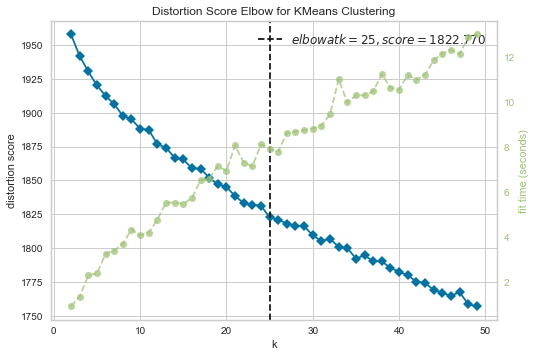

In [60]:
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(2,50), metric='distortion')

visualizer.fit(X_scaled)        # Fit the data to the visualizer
visualizer.show()

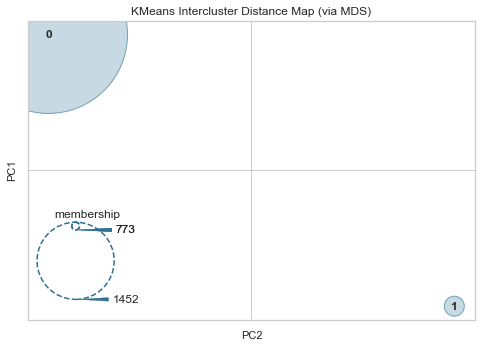

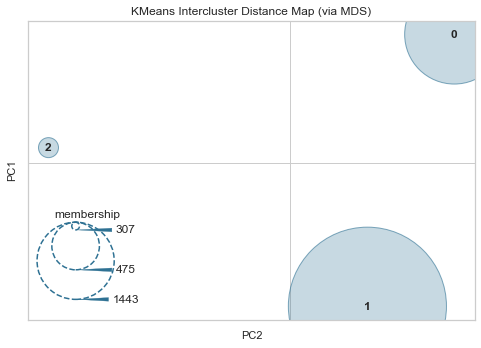

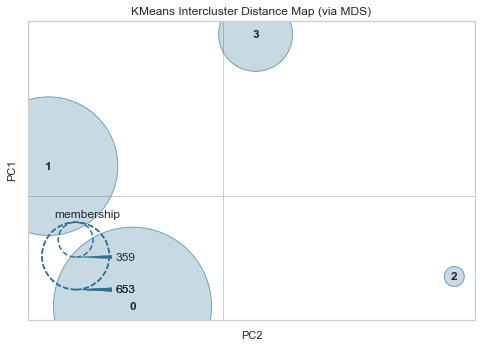

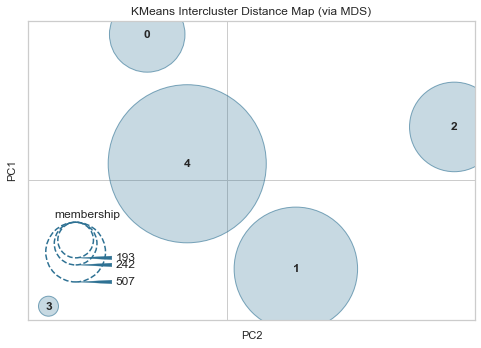

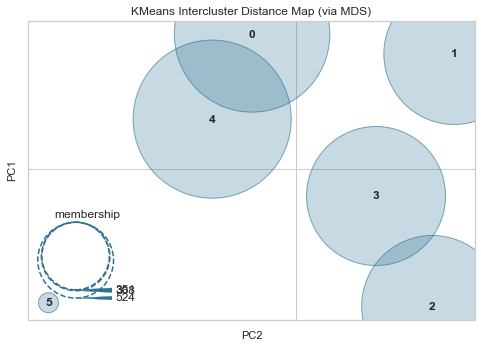

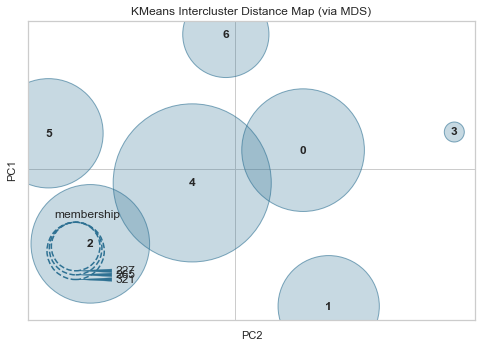

In [61]:
model = KMeans(2)
visualizer = InterclusterDistance(model)

visualizer.fit(X_scaled)        # Fit the data to the visualizer
visualizer.show()

model = KMeans(3)
visualizer = InterclusterDistance(model)

visualizer.fit(X_scaled)        # Fit the data to the visualizer
visualizer.show()

model = KMeans(4)
visualizer = InterclusterDistance(model)

visualizer.fit(X_scaled)        # Fit the data to the visualizer
visualizer.show()

model = KMeans(5)
visualizer = InterclusterDistance(model)

visualizer.fit(X_scaled)        # Fit the data to the visualizer
visualizer.show()

model = KMeans(6)
visualizer = InterclusterDistance(model)

visualizer.fit(X_scaled)        # Fit the data to the visualizer
visualizer.show()

model = KMeans(7)
visualizer = InterclusterDistance(model)

visualizer.fit(X_scaled)        # Fit the data to the visualizer
visualizer.show()

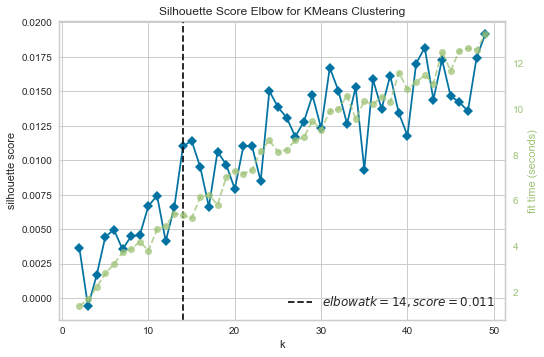

In [63]:
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(2,50), metric='silhouette', locate_elbow=True)

visualizer.fit(X_scaled)        # Fit the data to the visualizer
visualizer.show()


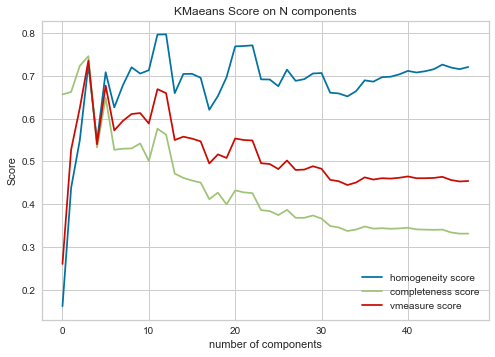

done


In [62]:
range_n_clusters = range(2, 50)
hscore = []
cscore = []
vscore = []
adjscore = []
for n_clusters in range_n_clusters:

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
#     print('before cluster here')
    clusterer = KMeans(n_clusters=n_clusters, random_state=1, algorithm='auto', max_iter=1000)
    cluster_labels = clusterer.fit(X_scaled)

    homogeneityscore = homogeneity_score(y_encode, cluster_labels.labels_)
    completenessscore = completeness_score(y_encode, cluster_labels.labels_)
    vmeasurescore = v_measure_score(y_encode, cluster_labels.labels_)
    
    hscore.append(homogeneityscore)  
    cscore.append(completenessscore)
    vscore.append(vmeasurescore) 
# print('here')   
plt.plot(hscore, label = "homogeneity score")
plt.plot(cscore, label = "completeness score")
plt.plot(vscore, label = "vmeasure score")

plt.xlabel('number of components')
plt.ylabel('Score')
plt.legend()
plt.title("KMaeans Score on N components")
plt.show()   
print('done')



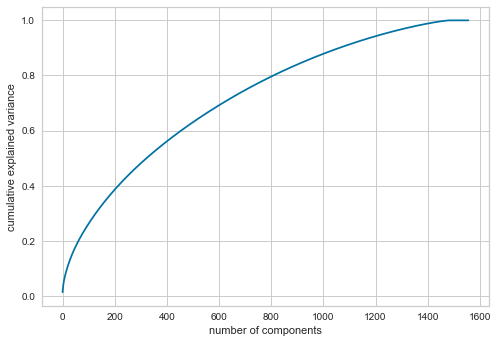

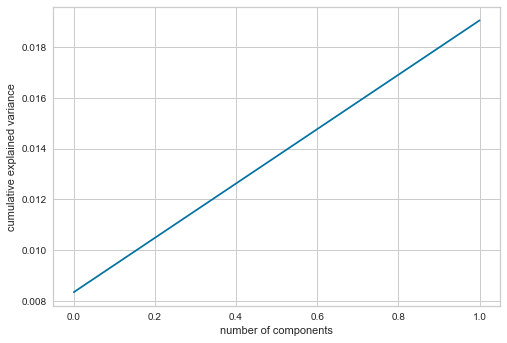

In [5]:
pca = PCA().fit(X_train.toarray())
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

pca = TruncatedSVD().fit(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()


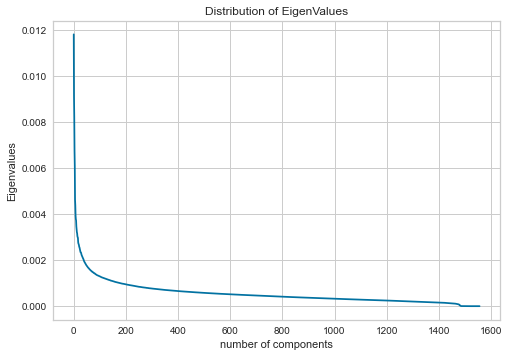

In [7]:
pca = PCA().fit(X_train.toarray())
plt.plot(pca.explained_variance_)
plt.xlabel('number of components')
plt.ylabel('Eigenvalues')
plt.title("Distribution of EigenValues")
plt.show()


[1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770, 780, 790, 800, 810, 820, 830, 840, 850, 860, 870, 880, 890, 900, 910, 920, 930, 940, 950, 960, 970, 980, 990, 1000, 1010, 1020, 1030, 1040, 1050, 1060, 1070, 1080, 1090, 1100, 1110, 1120, 1130, 1140, 1150, 1160, 1170, 1180, 1190, 1200, 1210, 1220, 1230, 1240, 1250, 1260, 1270, 1280, 1290, 1300]


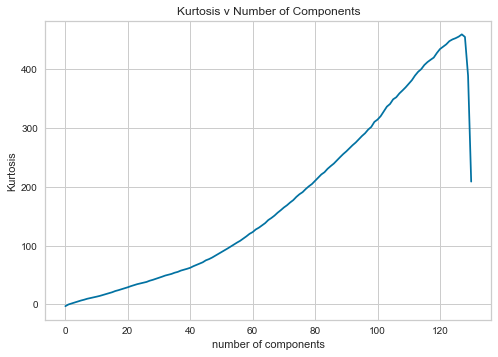

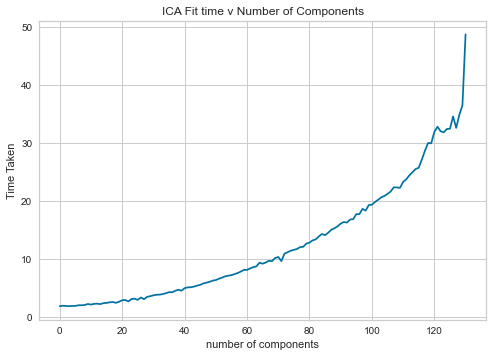

In [25]:
# components = range(1,100)
components = np.arange(0, 1310, 10).tolist()
components[0] = 1
print(components)
times = []
# print(components)
avg_kur_scores = []
for n_components in components:
    t1 = time.time()
    ica = FastICA(max_iter=100, algorithm='parallel', n_components=n_components).fit(X_train.toarray())
    t2 = time.time()
    times.append(-(t1-t2))
    kur = kurtosis(ica.components_, axis=0)
    avg_kur = np.average(kur)
    avg_kur_scores.append(avg_kur)
    # print(avg_kur)

plt.plot(avg_kur_scores)
plt.xlabel('number of components')
plt.ylabel('Kurtosis')
plt.title("Kurtosis v Number of Components")
plt.show()

plt.plot(times)
plt.xlabel('number of components')
plt.ylabel('Time Taken')
plt.title("ICA Fit time v Number of Components")
plt.show()

In [12]:
print(X_train.shape)
t1 = time.time()
ica = FastICA(max_iter=100, algorithm='parallel', n_components=1000).fit(X_train.toarray())
kur = kurtosis(ica.components_, axis=1)
t2 = time.time()
print(-(t1-t2))
print(np.average(kur))
print(ica.components_.shape)

(1335, 29421)
19.225220441818237
(1000, 29421)


In [17]:
print(X_train.shape)
t1 = time.time()
ica = FastICA(max_iter=100, algorithm='parallel').fit(X_train.toarray())
t2 = time.time()
kur = kurtosis(ica.components_, axis=1)
kur2 = kurtosis(ica.components_, axis=0)
print(-(t1-t2))
print('kur avg feat: ', np.average(kur))
print('kur avg comp: ', np.average(kur2))
print(-(t1-t2))
print(ica.components_.shape[1])
print(ica.components_.shape)
print('-----')

t1 = time.time()
ica = FastICA(max_iter=100, algorithm='parallel', n_components=900).fit(X_train.toarray())
t2 = time.time()
kur = kurtosis(ica.components_, axis=1)
kur2 = kurtosis(ica.components_, axis=0)
print(-(t1-t2))
print('kur avg feat: ', np.average(kur))
print('kur avg comp: ', np.average(kur2))
print(-(t1-t2))
print(ica.components_.shape[1])
print(ica.components_.shape)



(1335, 29421)
31.40850067138672
kur avg feat:  388.9165360326702
kur avg comp:  -1.1386671166876037
31.40850067138672
29421
(1335, 29421)
-----
15.00508189201355
kur avg feat:  1842.3493716512155
kur avg comp:  259.2419762804295
15.00508189201355
29421
(900, 29421)


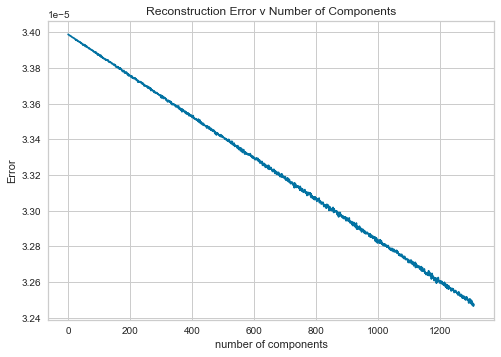

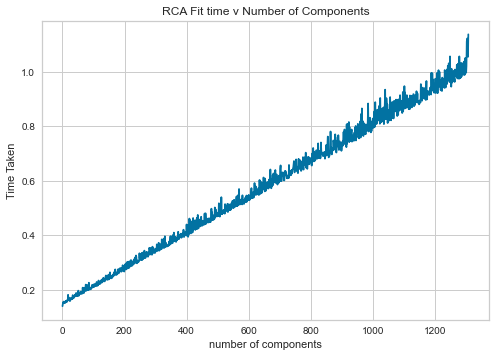

In [7]:
errors = []
times = []
n_components = range(1, 1310)
for n_component in n_components:
    rca = GaussianRandomProjection(n_components=n_component)
    t1 = time.time()
    rp = rca.fit_transform(X_train.toarray())
    t2 = time.time()
    times.append(-(t1-t2))
    inverse_data = np.linalg.pinv(rca.components_.T)
    reconstructed_data = rp.dot(inverse_data)
    error = mean_squared_error(X_train.toarray(), reconstructed_data)
    errors.append(error)

plt.plot(errors)
plt.xlabel('number of components')
plt.ylabel('Error')
plt.title("Reconstruction Error v Number of Components")
plt.show()

plt.plot(times)
plt.xlabel('number of components')
plt.ylabel('Time Taken')
plt.title("RCA Fit time v Number of Components")
plt.show()


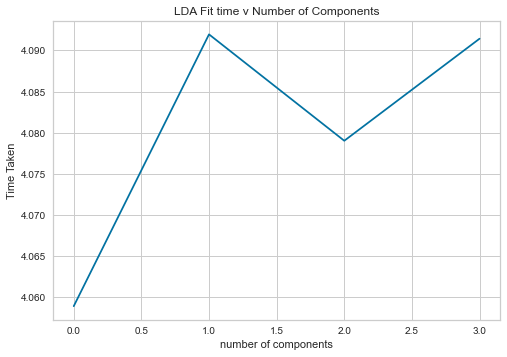

In [13]:
components = np.arange(1, 5).tolist()
# components[0] = 1
# components = range(1,560)
times = []
# print(components)
avg_LDA_scores = []
for n_components in components:
    t1 = time.time()
    lda = LinearDiscriminantAnalysis(n_components=n_components).fit(X_train.toarray(), y_train)
    t2 = time.time()
    times.append(-(t1-t2))

plt.plot(times)
plt.xlabel('number of components')
plt.ylabel('Time Taken')
plt.title("LDA Fit time v Number of Components")
plt.show()

#Uncomment for lda variance plot

# lda = LinearDiscriminantAnalysis().fit(X_train.toarray(), y_train)
# plt.plot(np.cumsum(lda.explained_variance_ratio_))
# plt.xlabel('number of components')
# plt.ylabel('cumulative explained variance')
# plt.xticks(range(0,4))
# plt.xlim(0, 3)
# plt.title('LDA - Variance v Number of Components')
# plt.show()

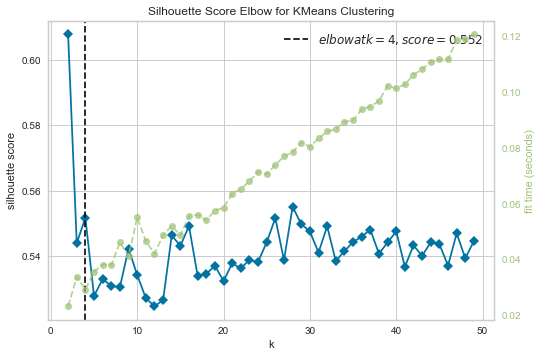

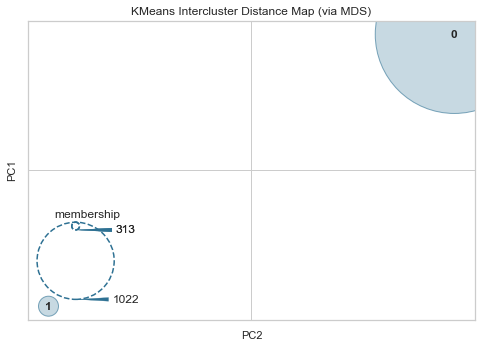

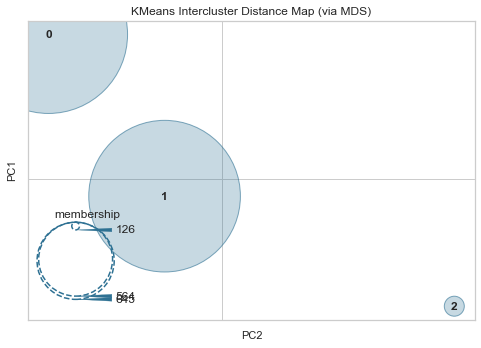

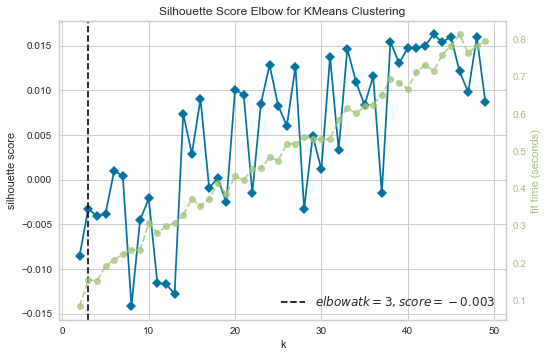

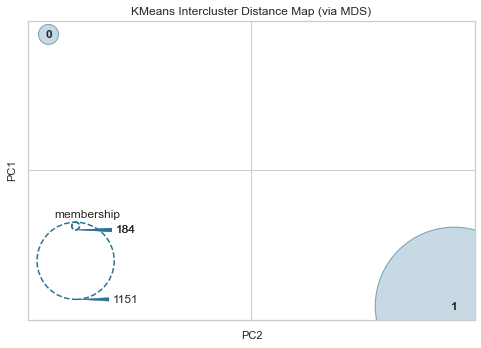

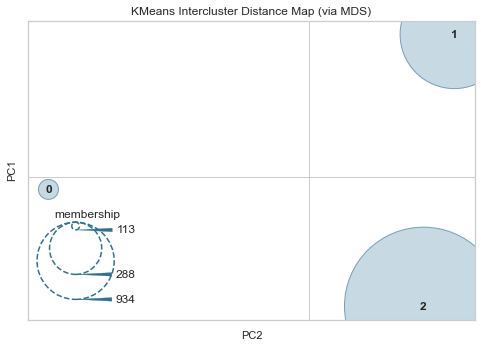

In [3]:
X_scaled_transform = X_train.toarray()
pca = PCA(n_components=1).fit(X_scaled_transform)
pca_train = pca.transform(X_scaled_transform)
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(2,50), metric='silhouette', locate_elbow=True)

visualizer.fit(pca_train)        # Fit the data to the visualizer
visualizer.show()

model = KMeans(2)
visualizer = InterclusterDistance(model)

visualizer.fit(pca_train)        # Fit the data to the visualizer
visualizer.show()

model = KMeans(3)
visualizer = InterclusterDistance(model)

visualizer.fit(pca_train)        # Fit the data to the visualizer
visualizer.show()

pca = PCA(n_components=800).fit(X_scaled_transform)
pca_train = pca.transform(X_scaled_transform)
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(2,50), metric='silhouette', locate_elbow=True)

visualizer.fit(pca_train)        # Fit the data to the visualizer
visualizer.show()

model = KMeans(2)
visualizer = InterclusterDistance(model)

visualizer.fit(pca_train)        # Fit the data to the visualizer
visualizer.show()

model = KMeans(3)
visualizer = InterclusterDistance(model)

visualizer.fit(pca_train)        # Fit the data to the visualizer
visualizer.show()

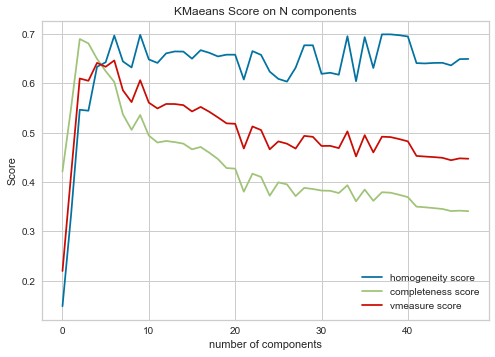

done


In [66]:
range_n_clusters = range(2, 50)
hscore = []
cscore = []
vscore = []
adjscore = []
X_scaled_transform = PCA(n_components=800).fit_transform(X_train.toarray())
for n_clusters in range_n_clusters:

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
#     print('before cluster here')
    clusterer = KMeans(n_clusters=n_clusters, random_state=1, algorithm='auto', max_iter=1000)
    cluster_labels = clusterer.fit(X_scaled_transform)

    homogeneityscore = homogeneity_score(y_train, cluster_labels.labels_)
    completenessscore = completeness_score(y_train, cluster_labels.labels_)
    vmeasurescore = v_measure_score(y_train, cluster_labels.labels_)
    
    hscore.append(homogeneityscore)  
    cscore.append(completenessscore)
    vscore.append(vmeasurescore) 
# print('here')   
plt.plot(hscore, label = "homogeneity score")
plt.plot(cscore, label = "completeness score")
plt.plot(vscore, label = "vmeasure score")

plt.xlabel('number of components')
plt.ylabel('Score')
plt.legend()
plt.title("KMaeans Score on N components")
plt.show()   
print('done')

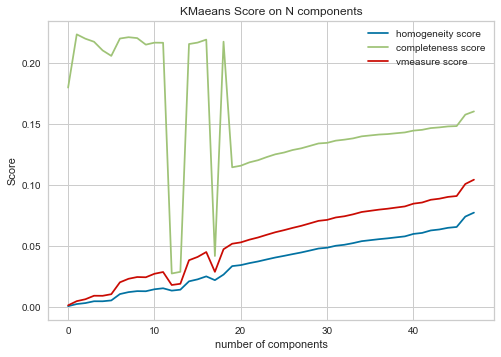

done


In [65]:
range_n_clusters = range(2, 50)
hscore = []
cscore = []
vscore = []
adjscore = []
X_scaled_transform = FastICA(max_iter=300, algorithm='parallel', n_components=1000).fit_transform(X_train.toarray())
for n_clusters in range_n_clusters:

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
#     print('before cluster here')
    clusterer = KMeans(n_clusters=n_clusters, random_state=1, algorithm='auto', max_iter=1000)
    cluster_labels = clusterer.fit(X_scaled_transform)

    homogeneityscore = homogeneity_score(y_train, cluster_labels.labels_)
    completenessscore = completeness_score(y_train, cluster_labels.labels_)
    vmeasurescore = v_measure_score(y_train, cluster_labels.labels_)
    
    hscore.append(homogeneityscore)  
    cscore.append(completenessscore)
    vscore.append(vmeasurescore) 
# print('here')   
plt.plot(hscore, label = "homogeneity score")
plt.plot(cscore, label = "completeness score")
plt.plot(vscore, label = "vmeasure score")

plt.xlabel('number of components')
plt.ylabel('Score')
plt.legend()
plt.title("KMaeans Score on N components")
plt.show()   
print('done')

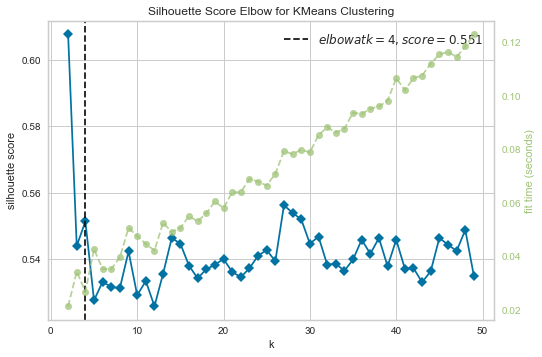

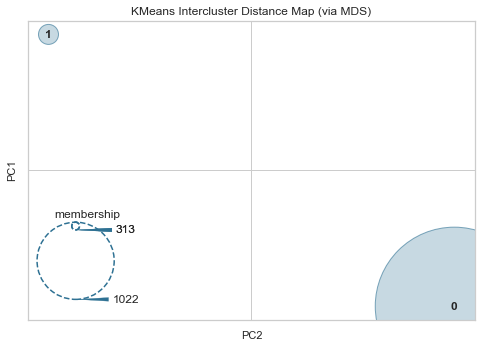

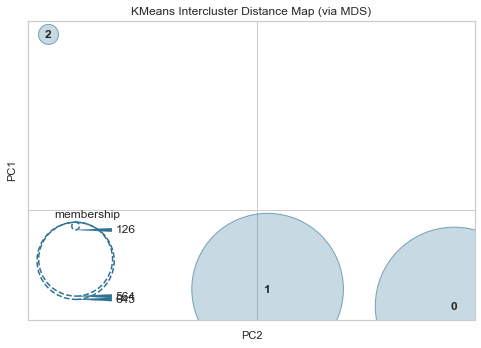

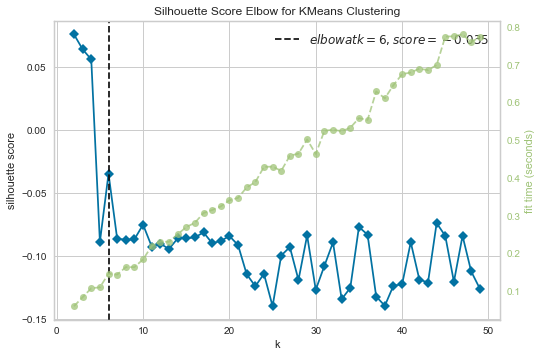

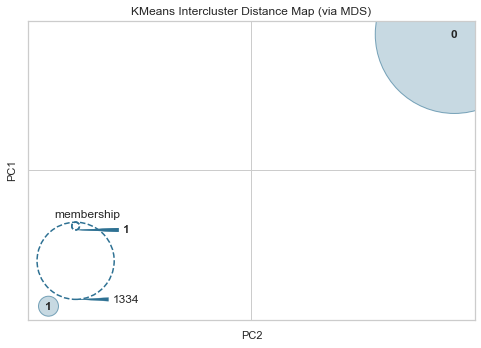

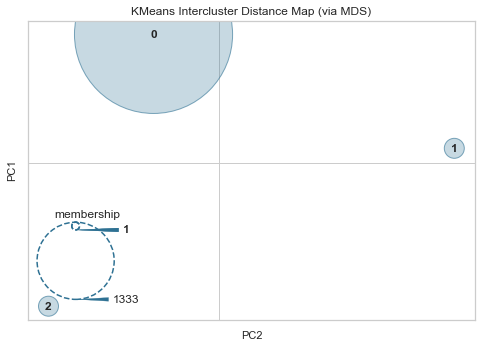

In [44]:
X_scaled_transform = X_train.toarray()
ica = FastICA(max_iter=300, algorithm='parallel', n_components=1).fit(X_scaled_transform)
ica_train = ica.transform(X_scaled_transform)
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(2,50), metric='silhouette', locate_elbow=True)


visualizer.fit(ica_train)        # Fit the data to the visualizer
visualizer.show()

model = KMeans(2)
visualizer = InterclusterDistance(model)

visualizer.fit(ica_train)        # Fit the data to the visualizer
visualizer.show()

model = KMeans(3)
visualizer = InterclusterDistance(model)

visualizer.fit(ica_train)        # Fit the data to the visualizer
visualizer.show()

ica = FastICA(max_iter=300, algorithm='parallel', n_components=1000).fit(X_scaled_transform)
ica_train = ica.transform(X_scaled_transform)
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(2,50), metric='silhouette', locate_elbow=True)


visualizer.fit(ica_train)        # Fit the data to the visualizer
visualizer.show()

model = KMeans(2)
visualizer = InterclusterDistance(model)

visualizer.fit(ica_train)        # Fit the data to the visualizer
visualizer.show()

model = KMeans(3)
visualizer = InterclusterDistance(model)

visualizer.fit(ica_train)        # Fit the data to the visualizer
visualizer.show()


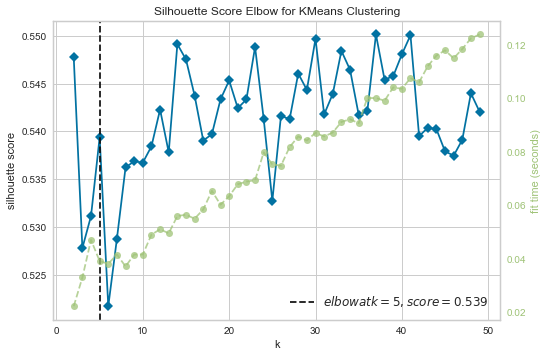

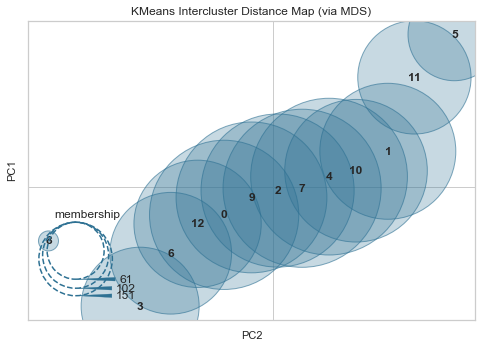

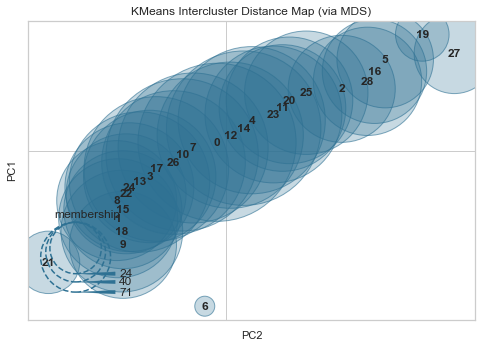

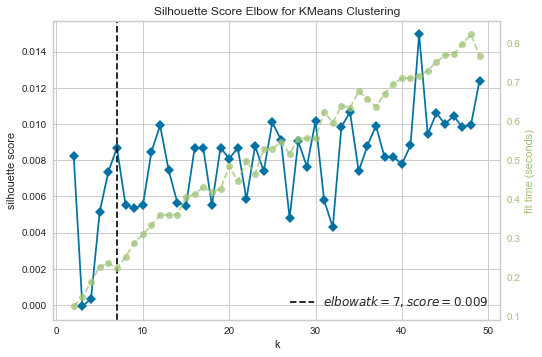

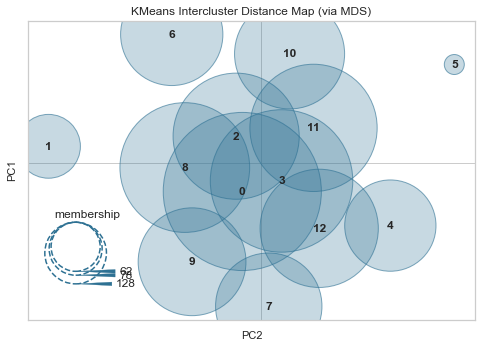

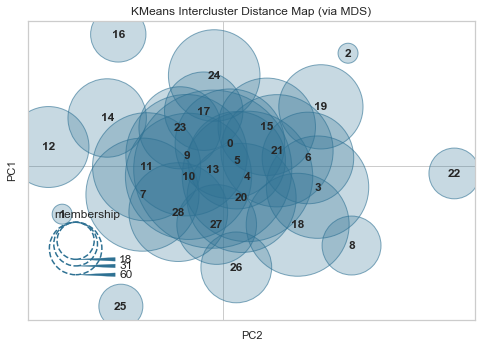

In [47]:
X_scaled_transform = X_train.toarray()
rca = GaussianRandomProjection(n_components=1).fit(X_scaled_transform)
rca_train = rca.transform(X_scaled_transform)
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(2,50), metric='silhouette', locate_elbow=True)


visualizer.fit(rca_train)        # Fit the data to the visualizer
visualizer.show()

model = KMeans(13)
visualizer = InterclusterDistance(model)

visualizer.fit(rca_train)        # Fit the data to the visualizer
visualizer.show()

model = KMeans(29)
visualizer = InterclusterDistance(model)

visualizer.fit(rca_train)        # Fit the data to the visualizer
visualizer.show()


rca = GaussianRandomProjection(n_components=800).fit(X_scaled_transform)
rca_train = rca.transform(X_scaled_transform)
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(2,50), metric='silhouette', locate_elbow=True)


visualizer.fit(rca_train)        # Fit the data to the visualizer
visualizer.show()

model = KMeans(13)
visualizer = InterclusterDistance(model)

visualizer.fit(rca_train)        # Fit the data to the visualizer
visualizer.show()

model = KMeans(29)
visualizer = InterclusterDistance(model)

visualizer.fit(rca_train)        # Fit the data to the visualizer
visualizer.show()


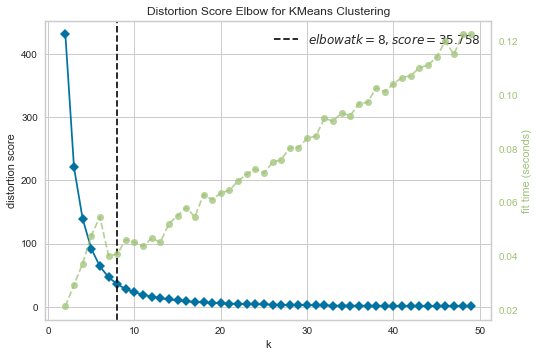

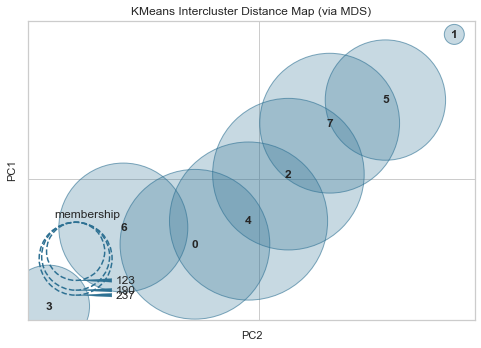

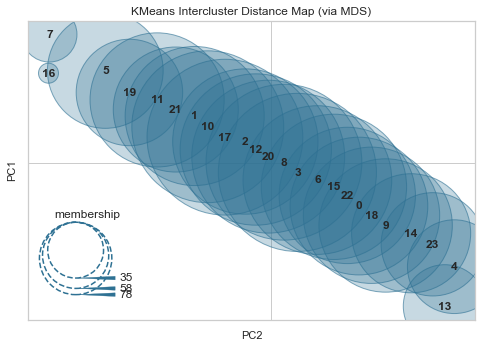

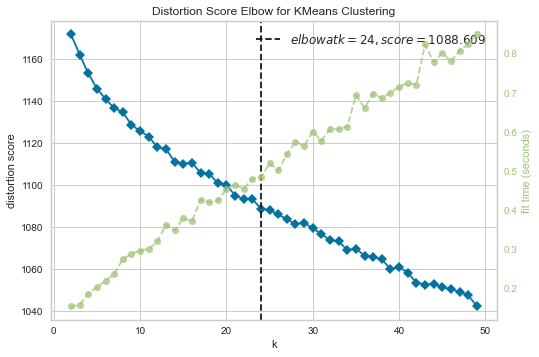

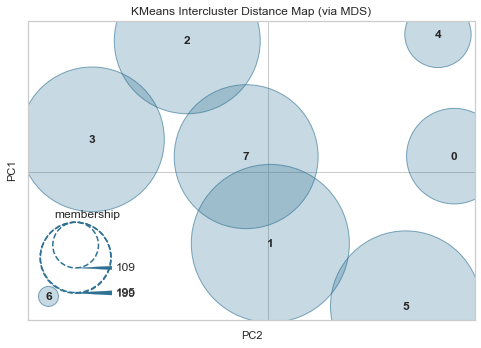

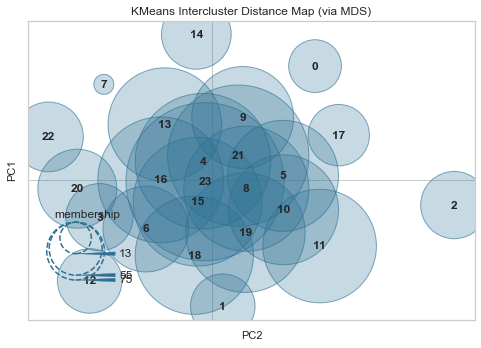

In [49]:
X_scaled_transform = X_train.toarray()
rca = GaussianRandomProjection(n_components=1).fit(X_scaled_transform)
rca_train = rca.transform(X_scaled_transform)
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(2,50), metric='distortion', locate_elbow=True)


visualizer.fit(rca_train)        # Fit the data to the visualizer
visualizer.show()

model = KMeans(8)
visualizer = InterclusterDistance(model)

visualizer.fit(rca_train)        # Fit the data to the visualizer
visualizer.show()

model = KMeans(24)
visualizer = InterclusterDistance(model)

visualizer.fit(rca_train)        # Fit the data to the visualizer
visualizer.show()


rca = GaussianRandomProjection(n_components=800).fit(X_scaled_transform)
rca_train = rca.transform(X_scaled_transform)
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(2,50), metric='distortion', locate_elbow=True)


visualizer.fit(rca_train)        # Fit the data to the visualizer
visualizer.show()

model = KMeans(8)
visualizer = InterclusterDistance(model)

visualizer.fit(rca_train)        # Fit the data to the visualizer
visualizer.show()

model = KMeans(24)
visualizer = InterclusterDistance(model)

visualizer.fit(rca_train)        # Fit the data to the visualizer
visualizer.show()

[0.57754311]


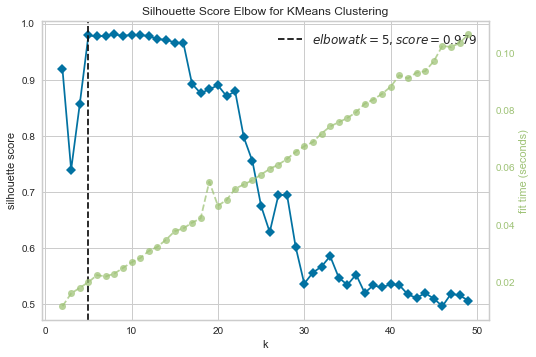

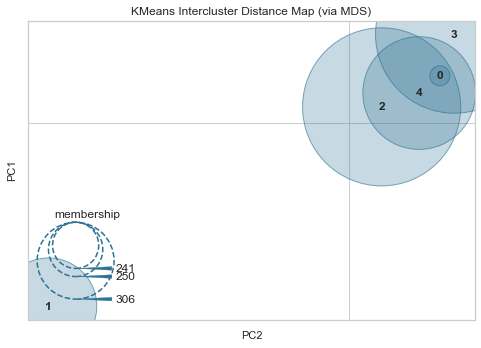

[0.57754311 0.85893461 0.98811478]


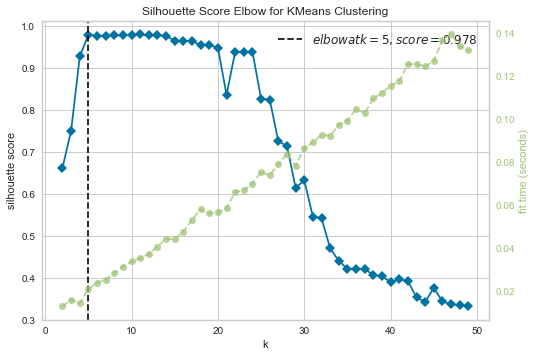

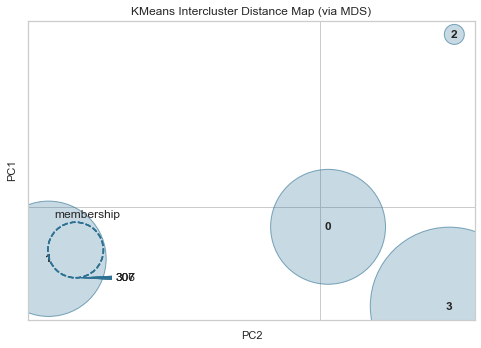

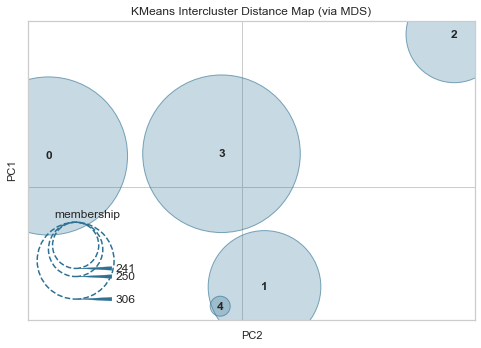

In [53]:
X_scaled_transform = X_train.toarray()
lda = LinearDiscriminantAnalysis(n_components=1).fit(X_scaled_transform, y_train)
print(np.cumsum(lda.explained_variance_ratio_))
lda_train = lda.transform(X_scaled_transform)
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(2,50), metric='silhouette', locate_elbow=True)


visualizer.fit(lda_train)        # Fit the data to the visualizer
visualizer.show()

model = KMeans(5)
visualizer = InterclusterDistance(model)

visualizer.fit(lda_train)        # Fit the data to the visualizer
visualizer.show()

lda = LinearDiscriminantAnalysis(n_components=3).fit(X_scaled_transform, y_train)
print(np.cumsum(lda.explained_variance_ratio_))
lda_train = lda.transform(X_scaled_transform)
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(2,50), metric='silhouette', locate_elbow=True)


visualizer.fit(lda_train)        # Fit the data to the visualizer
visualizer.show()

model = KMeans(4)
visualizer = InterclusterDistance(model)

visualizer.fit(lda_train)        # Fit the data to the visualizer
visualizer.show()

model = KMeans(5)
visualizer = InterclusterDistance(model)

visualizer.fit(lda_train)        # Fit the data to the visualizer
visualizer.show()

[0.57754311]


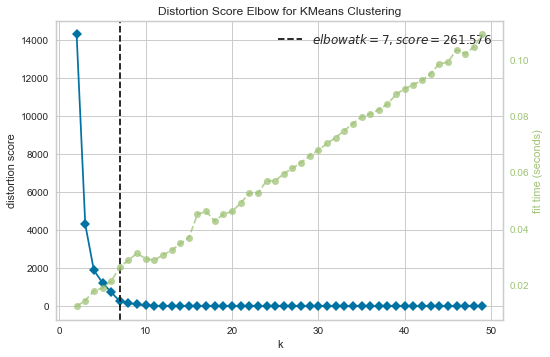

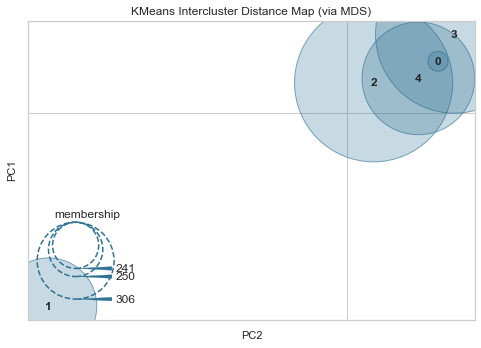

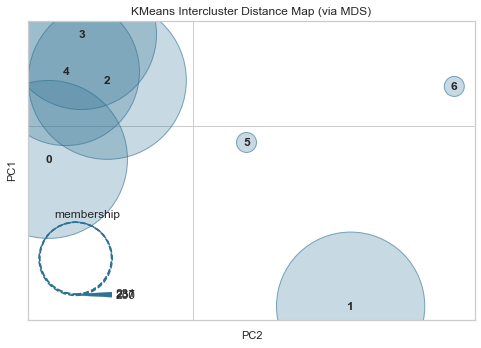

[0.57754311 0.85893461 0.98811478]


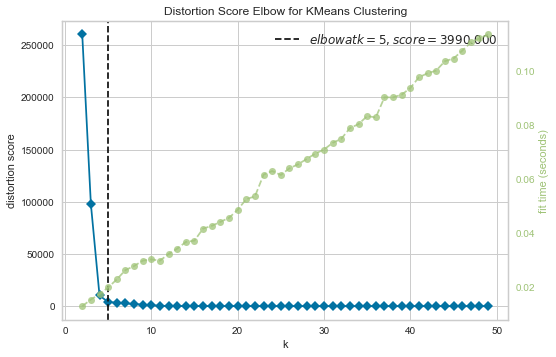

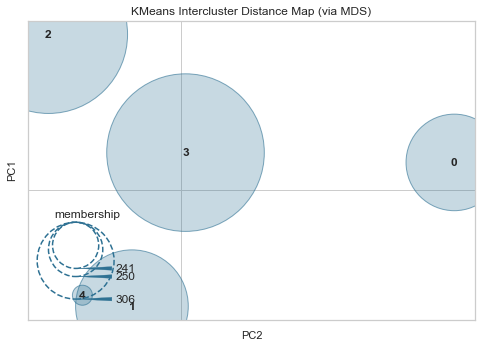

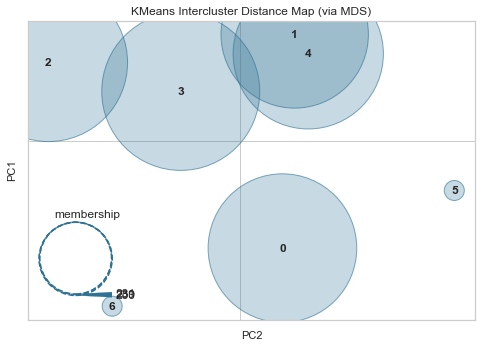

In [55]:
X_scaled_transform = X_train.toarray()
lda = LinearDiscriminantAnalysis(n_components=1).fit(X_scaled_transform, y_train)
print(np.cumsum(lda.explained_variance_ratio_))
lda_train = lda.transform(X_scaled_transform)
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(2,50), metric='distortion', locate_elbow=True)


visualizer.fit(lda_train)        # Fit the data to the visualizer
visualizer.show()

model = KMeans(5)
visualizer = InterclusterDistance(model)

visualizer.fit(lda_train)        # Fit the data to the visualizer
visualizer.show()

model = KMeans(7)
visualizer = InterclusterDistance(model)

visualizer.fit(lda_train)        # Fit the data to the visualizer
visualizer.show()


lda = LinearDiscriminantAnalysis(n_components=3).fit(X_scaled_transform, y_train)
print(np.cumsum(lda.explained_variance_ratio_))
lda_train = lda.transform(X_scaled_transform)
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(2,50), metric='distortion', locate_elbow=True)


visualizer.fit(lda_train)        # Fit the data to the visualizer
visualizer.show()

model = KMeans(5)
visualizer = InterclusterDistance(model)

visualizer.fit(lda_train)        # Fit the data to the visualizer
visualizer.show()

model = KMeans(7)
visualizer = InterclusterDistance(model)

visualizer.fit(lda_train)        # Fit the data to the visualizer
visualizer.show()

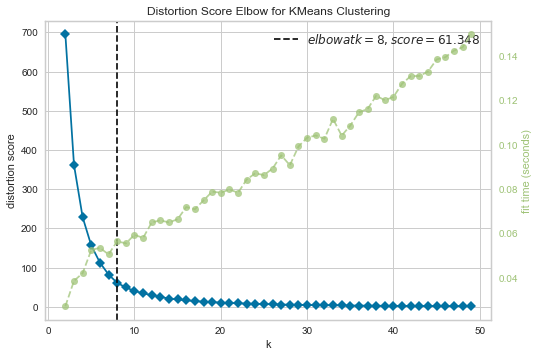

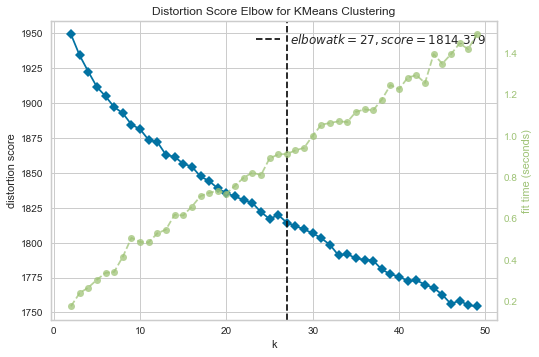

In [40]:
X_scaled_transform = X_scaled.toarray()
rca = GaussianRandomProjection(n_components=1).fit(X_scaled_transform)
rca_train = rca.transform(X_scaled_transform)
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(2,50), metric='distortion', locate_elbow=True)


visualizer.fit(rca_train)        # Fit the data to the visualizer
visualizer.show()

# model = KMeans(2)
# visualizer = InterclusterDistance(model)

# visualizer.fit(rca_train)        # Fit the data to the visualizer
# visualizer.show()

# model = KMeans(4)
# visualizer = InterclusterDistance(model)

# visualizer.fit(rca_train)        # Fit the data to the visualizer
# visualizer.show()


rca = GaussianRandomProjection(n_components=800).fit(X_scaled_transform)
rca_train = rca.transform(X_scaled_transform)
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(2,50), metric='distortion', locate_elbow=True)


visualizer.fit(rca_train)        # Fit the data to the visualizer
visualizer.show()

# model = KMeans(2)
# visualizer = InterclusterDistance(model)

# visualizer.fit(rca_train)        # Fit the data to the visualizer
# visualizer.show()

# model = KMeans(4)
# visualizer = InterclusterDistance(model)

# visualizer.fit(rca_train)        # Fit the data to the visualizer
# visualizer.show()

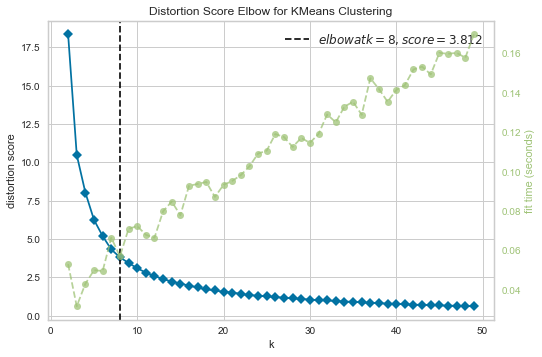

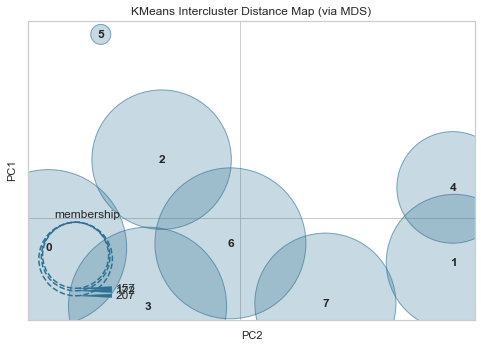

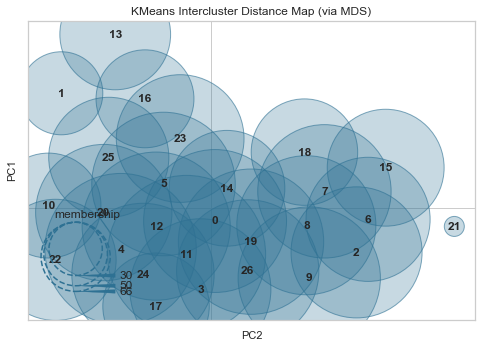

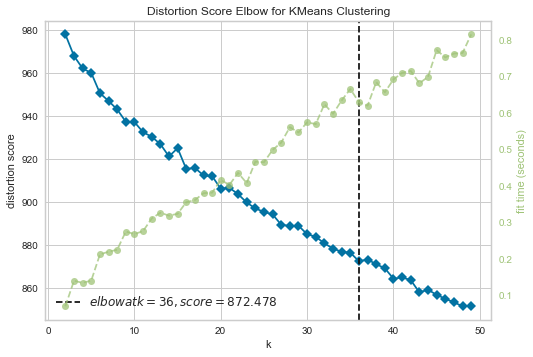

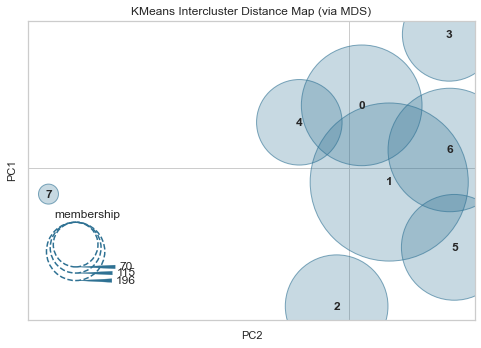

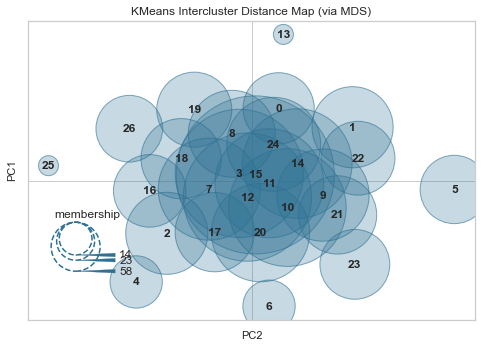

In [57]:
X_scaled_transform = X_train.toarray()
pca = PCA(n_components=2).fit(X_scaled_transform)
pca_train = pca.transform(X_scaled_transform)
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(2,50), metric='distortion', locate_elbow=True)

visualizer.fit(pca_train)        # Fit the data to the visualizer
visualizer.show()

model = KMeans(8)
visualizer = InterclusterDistance(model)

visualizer.fit(pca_train)        # Fit the data to the visualizer
visualizer.show()

model = KMeans(27)
visualizer = InterclusterDistance(model)

visualizer.fit(pca_train)        # Fit the data to the visualizer
visualizer.show()

pca = PCA(n_components=800).fit(X_scaled_transform)
pca_train = pca.transform(X_scaled_transform)
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(2,50), metric='distortion', locate_elbow=True)

visualizer.fit(pca_train)        # Fit the data to the visualizer
visualizer.show()

model = KMeans(8)
visualizer = InterclusterDistance(model)

visualizer.fit(pca_train)        # Fit the data to the visualizer
visualizer.show()

model = KMeans(27)
visualizer = InterclusterDistance(model)

visualizer.fit(pca_train)        # Fit the data to the visualizer
visualizer.show()

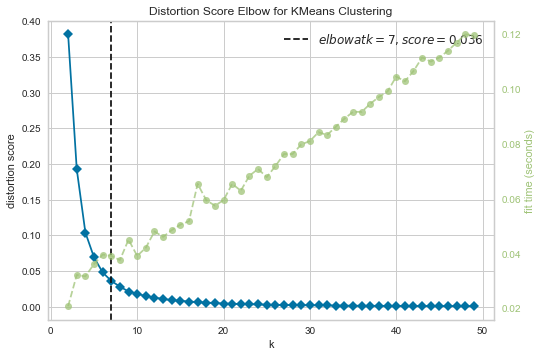

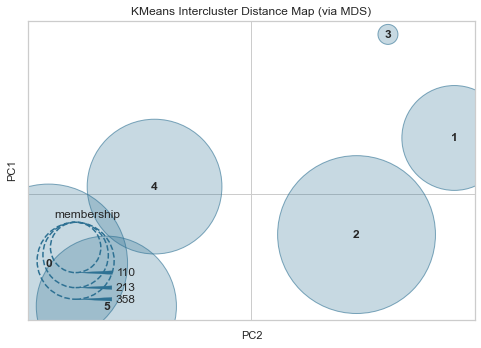

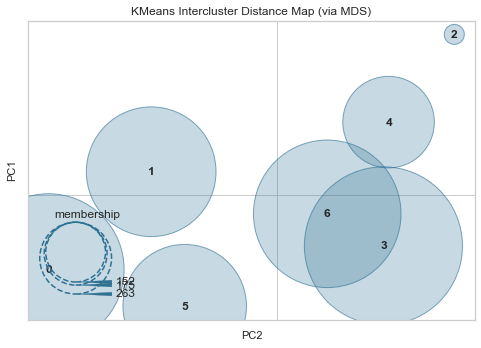

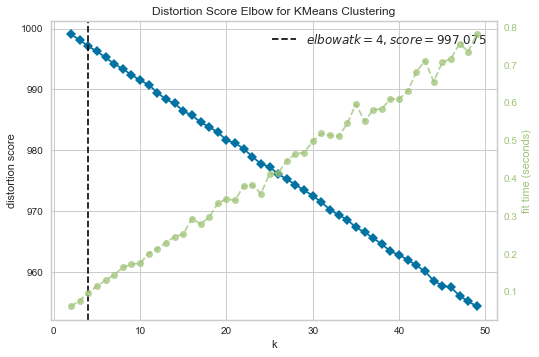

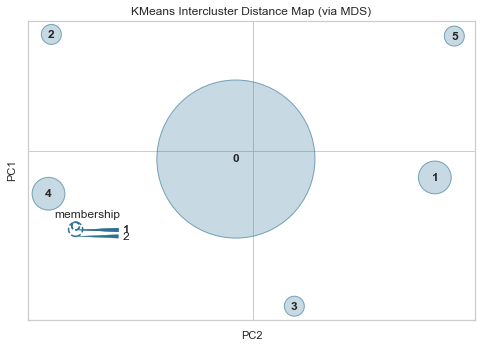

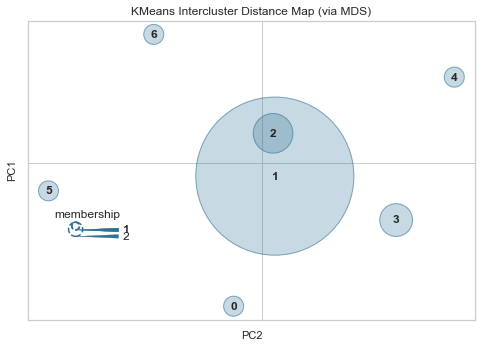

In [59]:
X_scaled_transform = X_train.toarray()
ica = FastICA(max_iter=300, algorithm='parallel', n_components=1).fit(X_scaled_transform)
ica_train = ica.transform(X_scaled_transform)
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(2,50), metric='distortion', locate_elbow=True)


visualizer.fit(ica_train)        # Fit the data to the visualizer
visualizer.show()

model = KMeans(6)
visualizer = InterclusterDistance(model)

visualizer.fit(ica_train)        # Fit the data to the visualizer
visualizer.show()

model = KMeans(7)
visualizer = InterclusterDistance(model)

visualizer.fit(ica_train)        # Fit the data to the visualizer
visualizer.show()

ica = FastICA(max_iter=300, algorithm='parallel', n_components=1000).fit(X_scaled_transform)
ica_train = ica.transform(X_scaled_transform)
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(2,50), metric='distortion', locate_elbow=True)


visualizer.fit(ica_train)        # Fit the data to the visualizer
visualizer.show()

model = KMeans(6)
visualizer = InterclusterDistance(model)

visualizer.fit(ica_train)        # Fit the data to the visualizer
visualizer.show()

model = KMeans(7)
visualizer = InterclusterDistance(model)

visualizer.fit(ica_train)        # Fit the data to the visualizer
visualizer.show()

In [11]:
X = vec.fit_transform(data['text'])
n_clust = 2
true_labels = y_label
k_means = KMeans(n_clusters = n_clust, random_state=123, n_init=10, max_iter=1000)
k_means.fit(X)
c_labels = k_means.labels_
df = pd.DataFrame({'clust_label': c_labels, 'orig_label': true_labels.tolist()})
ct = pd.crosstab(df['clust_label'], df['orig_label'])
y_clust = k_means.predict(X)
display(ct)
print('% 9s' % 'inertia  homo    compl   v-meas   ARI     AMI     silhouette')
print('%i   %.3f   %.3f   %.3f   %.3f   %.3f    %.3f'
  %(k_means.inertia_,
  homogeneity_score(true_labels, y_clust),
  completeness_score(true_labels, y_clust),
  v_measure_score(true_labels, y_clust),
  adjusted_rand_score(true_labels, y_clust),
  adjusted_mutual_info_score(true_labels, y_clust),
  silhouette_score(X, y_clust, metric='euclidean')))

n_clust = 5
k_means = KMeans(n_clusters = n_clust, random_state=123, n_init=10, max_iter=1000)
k_means.fit(X)
c_labels = k_means.labels_
df = pd.DataFrame({'clust_label': c_labels, 'orig_label': true_labels.tolist()})
ct = pd.crosstab(df['clust_label'], df['orig_label'])
y_clust = k_means.predict(X)
display(ct)
print('% 9s' % 'inertia  homo    compl   v-meas   ARI     AMI     silhouette')
print('%i   %.3f   %.3f   %.3f   %.3f   %.3f    %.3f'
  %(k_means.inertia_,
  homogeneity_score(true_labels, y_clust),
  completeness_score(true_labels, y_clust),
  v_measure_score(true_labels, y_clust),
  adjusted_rand_score(true_labels, y_clust),
  adjusted_mutual_info_score(true_labels, y_clust),
  silhouette_score(X, y_clust, metric='euclidean')))

orig_label,business,entertainment,politics,sport,tech
clust_label,,,,,
0,6,331,12,509,10
1,504,55,405,2,391


inertia  homo    compl   v-meas   ARI     AMI     silhouette
1957   0.332   0.795   0.468   0.326   0.468    0.010


orig_label,business,entertainment,politics,sport,tech
clust_label,,,,,
0,3,0,243,0,0
1,26,18,132,5,364
2,180,360,38,156,35
3,300,7,4,0,2
4,1,1,0,350,0


inertia  homo    compl   v-meas   ARI     AMI     silhouette
1921   0.551   0.580   0.565   0.439   0.564    0.003
